In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import norm
import statsmodels.api as sm

import calendar

import matplotlib.pyplot as plt
import seaborn as sns

import copy

%matplotlib inline
%load_ext autotime

In [2]:
data_orig = pd.read_csv("Bus_Breakdown_and_Delays.csv", parse_dates = [7])

time: 1min 25s


In [3]:
def clean_delay_times(x):
    
    if  not any(i.isdigit for i in x): # Filter trivial cases with no numbers.
        return np.nan
    
    if ('h' in x) or ('H' in x):
        return 60.0
    
    nondigits = []
    
    for i in x:
        if not i.isdigit():
            nondigits.append(i)

    for i in nondigits:
        x = x.replace(i, ',')
    
    x = x.split(',')

    for i in x:
        if len(i) > 0 and int(i) < 300.:
            return int(i)
        else:
            return np.nan

time: 7.31 ms


In [4]:
# Drop the 2020 data point
data_orig.drop(data_orig[data_orig['School_Year'] == '2019-2020'].index, inplace = True)
data_orig['delay_time'] = data_orig.How_Long_Delayed.astype(str).apply(clean_delay_times)

time: 2.41 s


In [5]:
data = copy.deepcopy(data_orig)

time: 75.6 ms


In [6]:
num_days_threshold = 250

data_heavy_traffic = data[data.Reason == 'Heavy Traffic']
data_accident = data[data.Reason == 'Accident']
data_problematic = data[data.Reason == 'Problem Run']
data_preventable_delay = data[(data.Reason == 'Mechanical Problem') | (data.Reason == 'Won`t Start') |
                             (data.Reason == 'Flat Tire')]# | (data.Reason == 'Problem Run')]


data_monthly = data.groupby([data['Occurred_On'].dt.year, data['Occurred_On'].dt.month,
              data['Occurred_On'].dt.day]).count()

data_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
data_monthly.drop(data_monthly[data_monthly['School_Year'] < num_days_threshold].index, axis = 0, inplace = True)
days_per_month = data_monthly.groupby(level = ['Year', 'Month']).count()[['School_Year']]
data_monthly = data_monthly.groupby(level = ['Year', 'Month']).sum()[['School_Year']]
data_monthly['days_per_month'] = days_per_month



heavy_traffic_monthly = data_heavy_traffic.groupby([data_heavy_traffic['Occurred_On'].dt.year, data_heavy_traffic['Occurred_On'].dt.month, data_heavy_traffic['Occurred_On'].dt.day])[['School_Year']].count()
heavy_traffic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_days_threshold].index, axis = 0, inplace = True)
heavy_traffic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
heavy_traffic_monthly = heavy_traffic_monthly.groupby(level = ['Year', 'Month']).sum()

preventable_delay_monthly = data_preventable_delay.groupby([data_preventable_delay['Occurred_On'].dt.year, data_preventable_delay['Occurred_On'].dt.month, data_preventable_delay['Occurred_On'].dt.day])[['School_Year']].count()
preventable_delay_monthly.drop(data_monthly[data_monthly['School_Year'] < num_days_threshold].index, axis = 0, inplace = True)
preventable_delay_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
preventable_delay_monthly = preventable_delay_monthly.groupby(level = ['Year', 'Month']).sum()

accidents_monthly = data_accident.groupby([data_accident['Occurred_On'].dt.year, data_accident['Occurred_On'].dt.month, data_accident['Occurred_On'].dt.day])[['School_Year']].count()
accidents_monthly.drop(data_monthly[data_monthly['School_Year'] < num_days_threshold].index, axis = 0, inplace = True)
accidents_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
accidents_monthly = accidents_monthly.groupby(level = ['Year', 'Month']).sum()

problematic_monthly = data_problematic.groupby([data_problematic['Occurred_On'].dt.year, data_problematic['Occurred_On'].dt.month, data_problematic['Occurred_On'].dt.day])[['School_Year']].count()
problematic_monthly.drop(data_monthly[data_monthly['School_Year'] < num_days_threshold].index, axis = 0, inplace = True)
problematic_monthly.index.set_names(['Year', 'Month', 'Day'], inplace = True)
problematic_monthly = problematic_monthly.groupby(level = ['Year', 'Month']).sum()

data_monthly['labels'] = data_monthly.index.map(lambda x: str(calendar.month_abbr[x[1]]) + " " + str(x[0]) )
data_monthly['heavy_traffic'] = heavy_traffic_monthly['School_Year']
data_monthly['preventable_delay'] = preventable_delay_monthly['School_Year']
data_monthly['accident'] = accidents_monthly['School_Year']
data_monthly['problematic'] = problematic_monthly['School_Year']
# display(data_monthly)


# Getting number of days since Sep 1, 2015
data_monthly['date_time'] = data_monthly.index.map(lambda x: (pd.datetime(x[0], x[1], 1) 
        - pd.datetime(data_monthly.index[0][0], data_monthly.index[0][1], 1)).days )

# Drop nan days_per_month
data_monthly.dropna(inplace = True)

# Get normalized delay frequency
data_monthly['normalized_delay_frequency'] = data_monthly['School_Year']/data_monthly['days_per_month']
data_monthly['normalized_heavy_traffic'] = data_monthly['heavy_traffic']/data_monthly['days_per_month']
data_monthly['normalized_preventable_delay'] = data_monthly['preventable_delay']/data_monthly['days_per_month']
data_monthly['normalized_accident'] = data_monthly['accident']/data_monthly['days_per_month']
data_monthly['normalized_problematic'] = data_monthly['problematic']/data_monthly['days_per_month']

# Change column name
data_monthly.rename(columns = {'School_Year': 'delay_frequency'}, inplace = True)

# Make labels and ticks for plotting
ticks = copy.deepcopy(data_monthly['date_time'])
labels = copy.deepcopy(data_monthly['labels'])

time: 1.04 s


In [7]:
alpha = 1

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_heavy_traffic']).reshape(-1, 1)

from sklearn.linear_model import LinearRegression, Ridge, Lasso

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_heavy'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_preventable_delay']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_preventable'] = lrm.predict(X_train)

X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_accident']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_accident'] = lrm.predict(X_train)


X_train = np.array(data_monthly['date_time']).reshape(-1, 1)
y_train = np.array(data_monthly['normalized_problematic']).reshape(-1, 1)

lrm = Ridge(alpha = alpha)

lrm.fit(X_train, y_train)

data_monthly['regression_fit_problematic'] = lrm.predict(X_train)

time: 116 ms


Text(0,0.5,'Average number of delays per day')

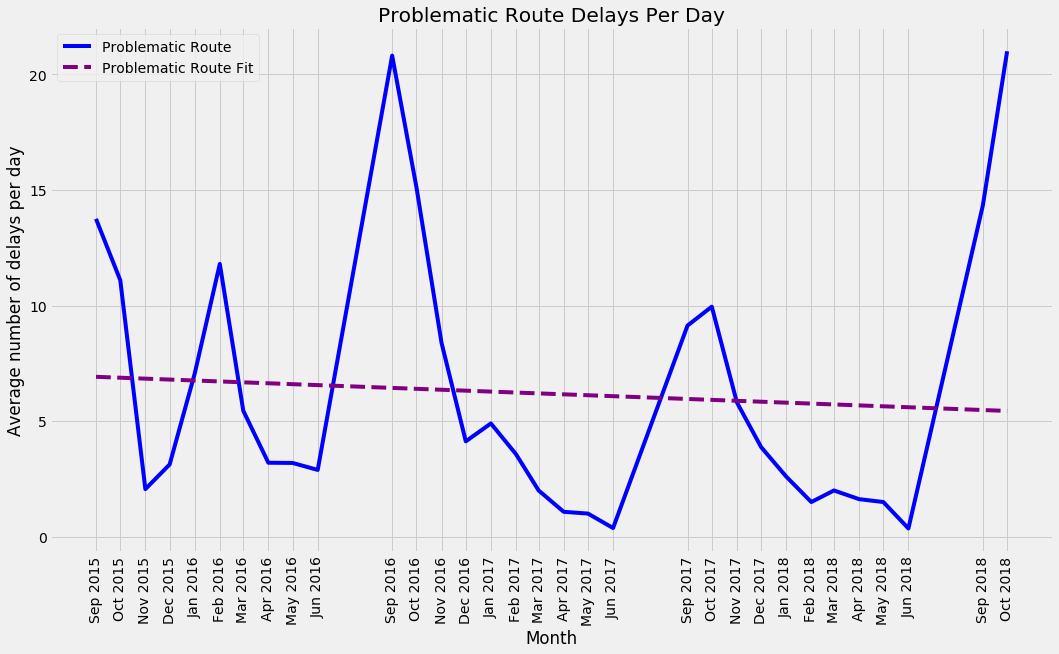

time: 956 ms


In [8]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_problematic'], label = 'Problematic Route', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_problematic'], label = 'Problematic Route Fit', linestyle = '--', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] + data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')
# plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'] - data_monthly['normalized_heavy_traffic'].std(), label = "", linestyle = ':', color = 'purple')

# plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'r')
# plt.plot(data_monthly['date_time'], regression_fit_preventable, label = 'Preventable Delay Fit ± std', linestyle = '--', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable + data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(data_monthly['date_time'], regression_fit_preventable - data_monthly['normalized_preventable_delay'].std(), linestyle = ':', color = 'pink')
# plt.plot(preventable_delay_monthly['Month'] , preventable_delay_monthly['School_Year'], label = 'All Delays')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Problematic Route Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0,0.5,'Average number of delays per day')

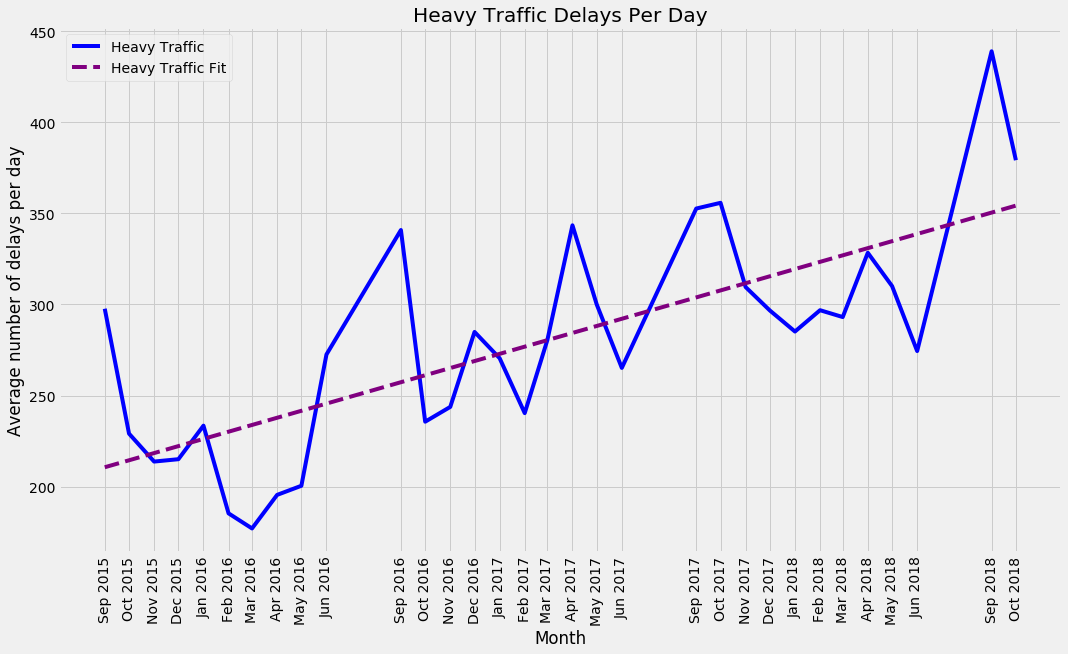

time: 925 ms


In [9]:
plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.plot(data_monthly['date_time'], data_monthly['normalized_heavy_traffic'], label = 'Heavy Traffic', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_heavy'], label = 'Heavy Traffic Fit', linestyle = '--', color = 'purple')


plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Heavy Traffic Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0,0.5,'Average number of delays per day')

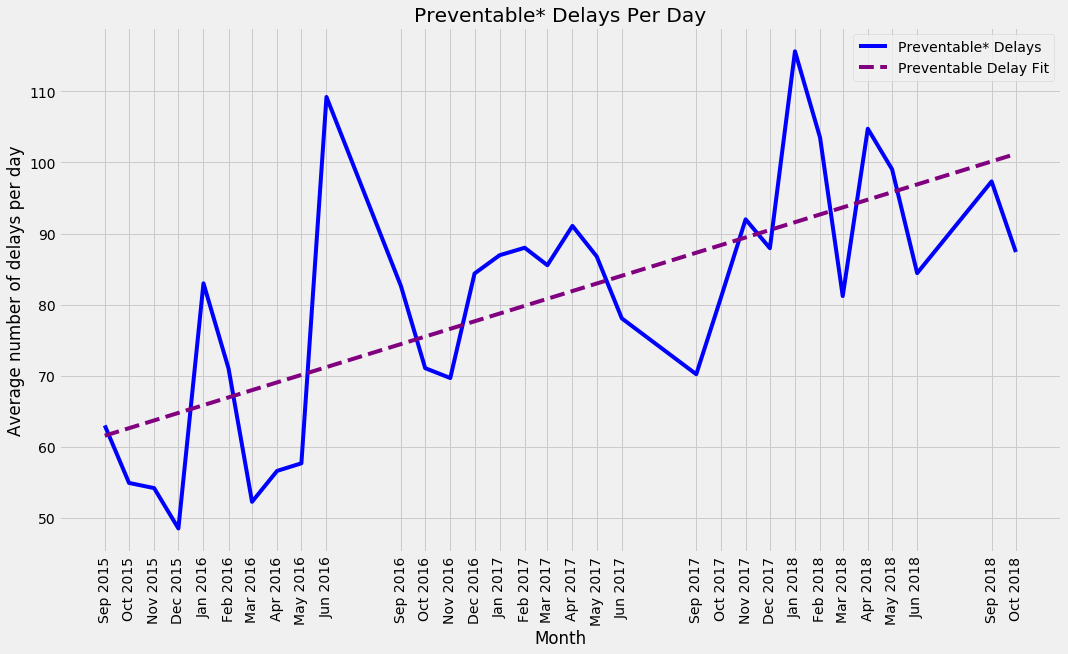

time: 937 ms


In [10]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_preventable_delay'], label = 'Preventable* Delays', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_preventable'], label = 'Preventable Delay Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Preventable* Delays Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of delays per day")

Text(0,0.5,'Average number of accidents per day')

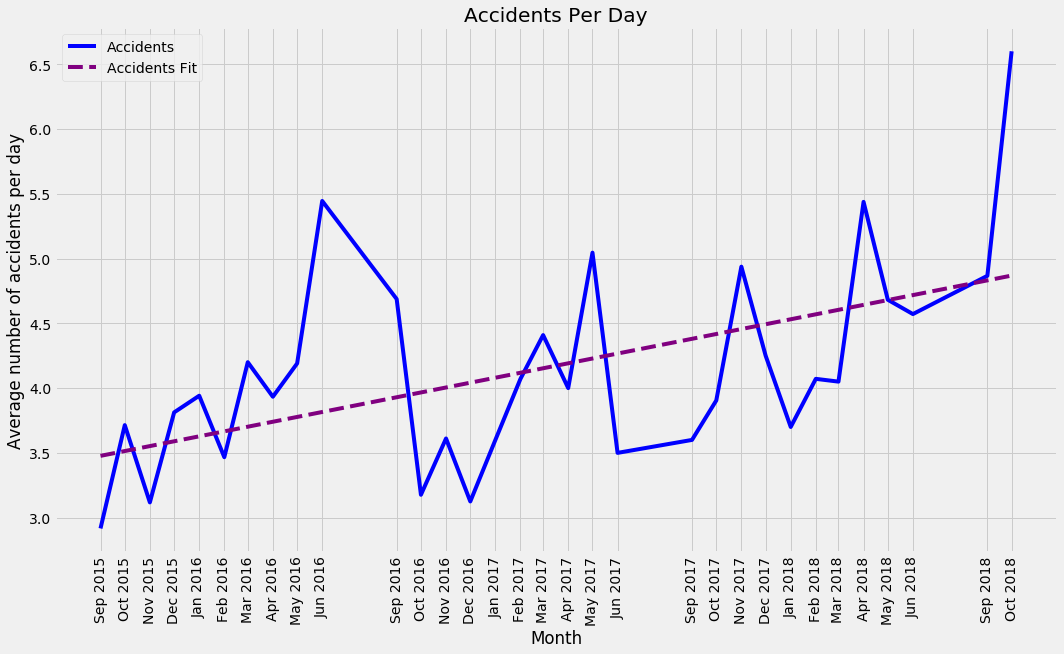

time: 1.02 s


In [11]:
plt.plot(data_monthly['date_time'], data_monthly['normalized_accident'], label = 'Accidents', color = 'b')
plt.plot(data_monthly['date_time'], data_monthly['regression_fit_accident'], label = 'Accidents Fit', linestyle = '--', color = 'purple')

plt.rcParams["figure.figsize"] = [16,9]
plt.style.use('fivethirtyeight')
plt.xticks(ticks, labels, rotation='vertical')
legend = plt.legend()
plt.setp(legend.get_texts(), color='Black')
plt.title("Accidents Per Day", color = 'Black')
plt.xlabel("Month")
plt.ylabel("Average number of accidents per day")

In [12]:
data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
data_g.drop('All Boroughs', level = 'Boro', inplace = True)

total = np.array(data_g.merge(data_g.groupby(level = 'Boro').sum()[['Number_delays']], on = 'Boro')['Number_delays_y'])
data_g['total'] = total

data_g['Percent'] = 100*data_g['Number_delays'].astype(float)/data_g['total'].astype(float)

data_g.drop(columns = 'total', inplace = True)

data_g.to_csv("reason_for_delay_by_borough.csv")

time: 542 ms


In [13]:
# Quick code to find out whether traffic delays are heavier in one borough vs another.
# Look at ratio of heavy traffic delays to non heavy traffic delays by borough.

data_g = data
data_g['Heavy_Traffic'] = [(x == 'Heavy Traffic') for x in data_g['Reason']]

data_g = data.groupby(['Boro', 'Reason']).count()
data_g = data_g[['School_Year']]
data_g.rename(columns = {'School_Year':'Number_delays'}, inplace = True)
# data_g.drop('All Boroughs', level = 'Boro').to_csv("reason_for_delay_by_borough.csv")
# For a given Boro, divide the School_Year associated with Heavy_Traffic == True by the false.

time: 509 ms


In [14]:
# Look at delays by runtype and delay type.

df = pd.DataFrame()
for i in data['Run_Type'].unique():
    new_df = pd.DataFrame(data[data['Run_Type'] == i]['Reason'].value_counts()*100/len(data[data['Run_Type'] == i]))
    new_df['Run_Type'] = i
    new_df['Number_delays'] = data[data['Run_Type'] == i]['Reason'].value_counts()
    df = pd.concat([df, new_df])
#     print (i, "\n", data[data['Run_Type'] == i]['Reason'].value_counts()/len(data[data['Run_Type'] == i]), "\n")

df.rename(columns = {'Reason': 'Percent_delay'}, inplace = True)
# df
# df.to_csv("delay_by_runtype_and_delaytype.csv")

time: 1.68 s
